## 🛰️ KNN Satellite Image Classification

This notebook implements a K-Nearest Neighbors (KNN) classifier for the EuroSAT satellite image dataset using features like color histograms and basic statistics.

### Step 1: Import Libraries

Import necessary libraries for data handling, image processing, machine learning, and visualization.

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Machine Learning & Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from sklearn.utils import shuffle 

# Set plot style
sns.set_style("whitegrid")

print("✅ Libraries imported successfully.")

✅ Libraries imported successfully.


### Step 2: Load Dataset, Preprocess (Median Blur), and Extract Features

Load images, resize them, apply a median blur to reduce noise, and extract 54 features (color histograms + channel mean/std) for each image.

⏳ Loading images, applying median blur, and extracting features...



✅ Loaded and processed images: 27000
Feature matrix shape: (27000, 54)
Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


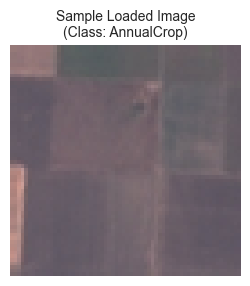

In [2]:
DATASET_DIR = r"./EuroSAT/2750" 
IMG_SIZE = 64
HIST_BINS = 16

def is_image_file(filename):
    """Check if a filename has a common image extension."""
    ext = filename.lower().split('.')[-1]
    return ext in ('jpg','jpeg','png','tif','tiff','bmp')

def extract_features_from_image(img, hist_bins=16):
    """Extract color histogram and mean/std features from an RGB image."""
    # img should be RGB, shape (IMG_SIZE, IMG_SIZE, 3)

    # 1) Color histograms per channel (normalized)
    chans = cv2.split(img)
    hist_features = []
    for ch in chans:
        # Ensure channel is uint8 if calcHist requires it
        ch_uint8 = cv2.normalize(ch, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        hist = cv2.calcHist([ch_uint8], [0], None, [hist_bins], [0,256])
        hist = hist.flatten()
        hist = hist / (hist.sum() + 1e-8) 
        hist_features.append(hist)
    hist_features = np.concatenate(hist_features)

    # 2) Per-channel mean and std (use original channel data)
    means = [ch.mean() for ch in chans]
    stds  = [ch.std()  for ch in chans]

    # Combine features
    feat = np.concatenate([hist_features, means, stds])
    return feat


X = []
y = []
classes = []
image_paths = [] 
first_image_loaded = None 
first_image_path = ""
image_count = 0

print("⏳ Loading images, applying median blur, and extracting features...")
for class_name in sorted(os.listdir(DATASET_DIR)):
    class_path = os.path.join(DATASET_DIR, class_name)
    if not os.path.isdir(class_path):
        continue
    classes.append(class_name)
    image_list = sorted(os.listdir(class_path))
    for fname in tqdm(image_list, desc=class_name, leave=False):
        if fname.startswith('.') or not is_image_file(fname):
            continue
        img_path = os.path.join(class_path, fname)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            print(f"⚠️ Warning: Could not read image {img_path}")
            continue

        # Convert BGR -> RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize
        img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))

        # --- Apply Median Blur --- 
        img_filtered = cv2.medianBlur(img_resized, 3) # Kernel size 3x3

        # --- Extract features from the filtered image ---
        feat = extract_features_from_image(img_filtered, hist_bins=HIST_BINS)

        X.append(feat)
        y.append(class_name)
        image_paths.append(img_path) 
        image_count += 1
        
        # Store the first image for visualization
        if first_image_loaded is None:
            first_image_loaded = img_resized
            first_image_path = img_path

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=object)

print(f"\n✅ Loaded and processed images: {image_count}")
print(f"Feature matrix shape: {X.shape}")
print(f"Classes: {classes}")

# --- Visualization: Show the first loaded image ---
if first_image_loaded is not None:
    plt.figure(figsize=(3, 3))
    plt.imshow(first_image_loaded)
    plt.title(f"Sample Loaded Image\n(Class: {y[0]})", fontsize=10)
    plt.axis('off')
    plt.show()
else:
    print("No images were loaded to display a sample.")

### Step 2.1: Visualize Preprocessing Steps

Show an example image in its original (resized) state, after conceptual normalization (scaling to 0-1 for display), and after applying the median filter.

Visualizing preprocessing steps for: ./EuroSAT/2750\AnnualCrop\AnnualCrop_1.jpg


C:\Users\APL TECH\AppData\Local\Temp\ipykernel_12596\1001132322.py:29: UserWarning: Glyph 128752 (\N{SATELLITE}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\APL TECH\AppData\Local\Temp\ipykernel_12596\1001132322.py:29: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\APL TECH\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128752 (\N{SATELLITE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\APL TECH\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


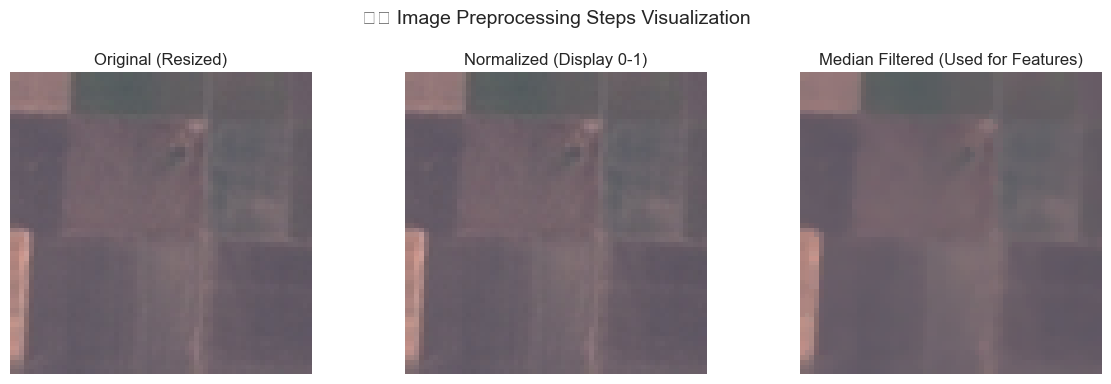

In [3]:
def visualize_preprocessing(img_path, img_size=64):
    """Show original, normalized concept, and filtered versions of a satellite image."""
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        print(f"❌ Cannot open image file for visualization: {img_path}")
        return

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (img_size, img_size))

    # Normalization concept (display scaled 0-1)
    img_norm_display = img_resized / 255.0 
    img_norm_display = np.clip(img_norm_display, 0, 1) 

    # Median Filtered (as applied in Step 2)
    img_filtered = cv2.medianBlur(img_resized, 3)

    # --- Visualization ---
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    titles = ["Original (Resized)", "Normalized (Display 0-1)", "Median Filtered (Used for Features)"]
    imgs = [img_resized, img_norm_display, img_filtered]

    for ax, title, im in zip(axes, titles, imgs):
        ax.imshow(im)
        ax.set_title(title)
        ax.axis("off")

    plt.suptitle("🛰️ Image Preprocessing Steps Visualization", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()

# Visualize preprocessing on the first loaded image
if first_image_path:
    print(f"Visualizing preprocessing steps for: {first_image_path}")
    visualize_preprocessing(first_image_path, img_size=IMG_SIZE)
else:
    print("No image path stored, skipping preprocessing visualization.")

### Step 3: Feature Extraction Recap

Confirm the shape of the extracted feature matrix (samples x features).

In [4]:
print(f"✅ Feature extraction recap — total samples: {len(X)}, feature size: {X.shape[1]}")

✅ Feature extraction recap — total samples: 27000, feature size: 54


### Step 4: Normalize Features

Standardize the features using `StandardScaler` (mean=0, std=1) so that all features contribute equally.

✅ Features normalized.
Mean (after scaling): -0.0
Std (after scaling): 1.0


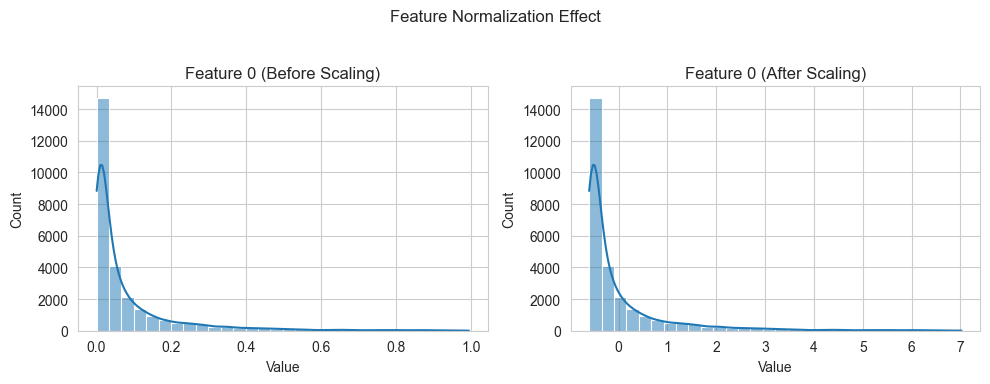

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✅ Features normalized.")
print(f"Mean (after scaling): {np.round(X_scaled.mean(), 4)}")
print(f"Std (after scaling): {np.round(X_scaled.std(), 4)}")

# --- Visualization: Compare distribution of one feature before and after scaling ---
feature_index_to_plot = 0 

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.histplot(X[:, feature_index_to_plot], kde=True, bins=30)
plt.title(f"Feature {feature_index_to_plot} (Before Scaling)")
plt.xlabel("Value")

plt.subplot(1, 2, 2)
sns.histplot(X_scaled[:, feature_index_to_plot], kde=True, bins=30)
plt.title(f"Feature {feature_index_to_plot} (After Scaling)")
plt.xlabel("Value")

plt.suptitle("Feature Normalization Effect")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Step 5: Dimensionality Reduction (PCA)

Apply Principal Component Analysis (PCA) to reduce the feature dimensions while retaining ~98% of the variance.

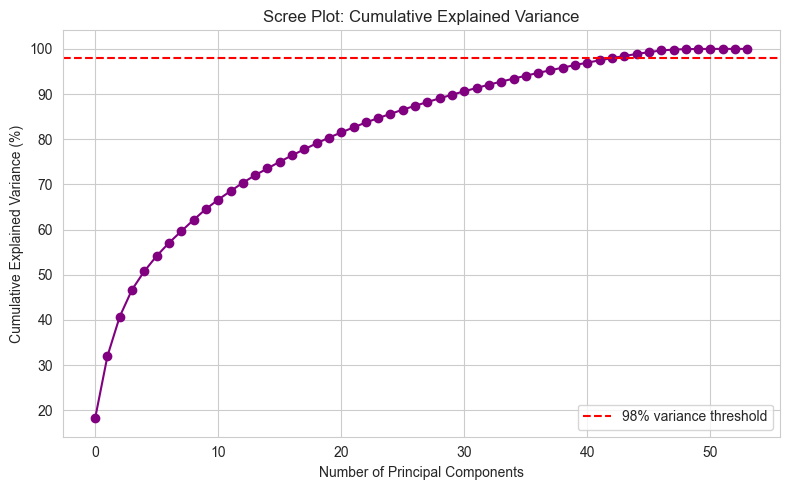

✅ PCA applied successfully.
Original feature size: 54
Reduced feature size:  44
Total explained variance: 98.43%


In [11]:
# --- Visualization: Scree Plot to determine components ---
pca_test = PCA()
pca_test.fit(X_scaled)

explained_variance_ratio = np.cumsum(pca_test.explained_variance_ratio_) * 100

plt.figure(figsize=(8, 5))
plt.plot(explained_variance_ratio, marker='o', color='purple')
plt.axhline(y=98, color='r', linestyle='--', label='98% variance threshold')
plt.title("Scree Plot: Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Apply PCA --- 
pca = PCA(n_components=0.98, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Display summary
print("✅ PCA applied successfully.")
print(f"Original feature size: {X_scaled.shape[1]}")
print(f"Reduced feature size:  {X_pca.shape[1]}")
print(f"Total explained variance: {np.sum(pca.explained_variance_ratio_)*100:.2f}%")

### Step 6 — Train/Test Split

Split the PCA-transformed data into training (80%) and testing (20%) sets, ensuring class balance (stratification).

✅ Data successfully split.
Training samples: 21600
Testing samples:  5400


C:\Users\APL TECH\AppData\Local\Temp\ipykernel_12596\2149260202.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=y_train, order=np.unique(y_train), palette='viridis')
C:\Users\APL TECH\AppData\Local\Temp\ipykernel_12596\2149260202.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=y_test, order=np.unique(y_test), palette='viridis')


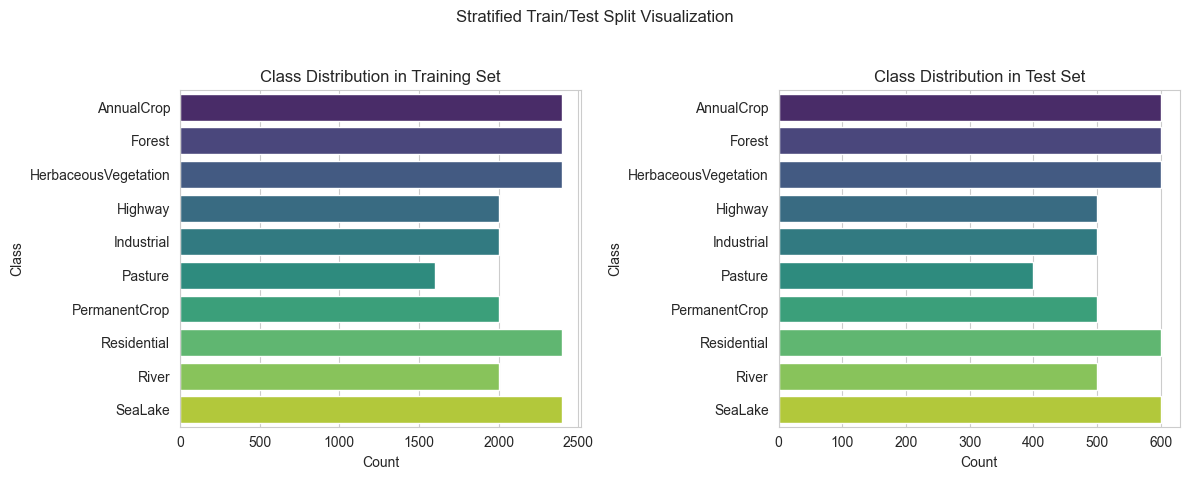

In [12]:
X_train, X_test, y_train, y_test, paths_train, paths_test = train_test_split(
    X_pca, y, image_paths, 
    test_size=0.2,
    random_state=42,
    stratify=y,
    shuffle=True
)

print("✅ Data successfully split.")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples:  {X_test.shape[0]}")

# --- Visualization: Class distribution in train and test sets ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(y=y_train, order=np.unique(y_train), palette='viridis')
plt.title('Class Distribution in Training Set')
plt.xlabel('Count')
plt.ylabel('Class')

plt.subplot(1, 2, 2)
sns.countplot(y=y_test, order=np.unique(y_test), palette='viridis')
plt.title('Class Distribution in Test Set')
plt.xlabel('Count')
plt.ylabel('Class')

plt.suptitle('Stratified Train/Test Split Visualization')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Step 7 — Train & Optimize KNN (with GridSearchCV)

Use GridSearchCV to find the best hyperparameters (number of neighbors, weights, metric) for the KNN model using 5-fold cross-validation.

⏳ Starting GridSearchCV for KNN...
Fitting 5 folds for each of 162 candidates, totalling 810 fits


C:\Users\APL TECH\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.63875    0.6399537  0.63875    0.6399537  0.63875    0.6399537
 0.64731481 0.65060185 0.64731481 0.65060185 0.64731481 0.65060185
 0.64935185 0.65430556 0.64935185 0.65430556 0.64935185 0.65430556
 0.64712963 0.64939815 0.64712963 0.64939815 0.64712963 0.64939815
 0.64689815 0.6499537  0.64689815 0.6499537  0.64689815 0.6499537
 0.64444444 0.64787037 0.64444444 0.64787037 0.64444444 0.64787037
 0.64324074 0.64513889 0.64324074 0.64513889 0.64324074 0.64513889
 0.64027778 0.64453704 0.64027778 0.64453704 0.64027778 0.64453704
 0.63726852 0.64240741 0.63726852 0.64240741 0.63726852 0.64240741
        nan 0.63449074        nan 0.63449074        nan 0.63449074
        nan 0.64018519        nan 0.64018519        nan 0.64018519
        nan 0.64296296        nan 0.64296296        nan 0.64296296
        nan 0.64208333        na


✅ GridSearch complete.
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best Cross-Validation Accuracy: 65.43%


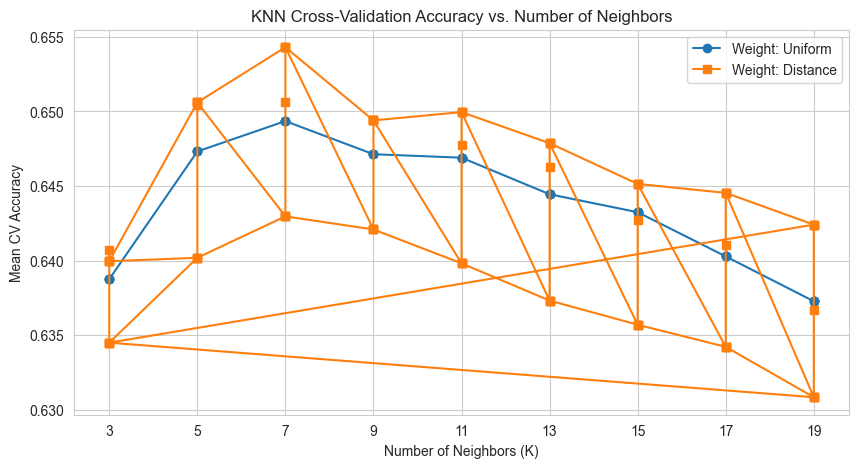

In [18]:
knn = KNeighborsClassifier()

# Define hyperparameter grid 
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 1.5, 2]  
}


# GridSearch with 5-fold CV
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

print("⏳ Starting GridSearchCV for KNN...")
grid_search.fit(X_train, y_train)

# Best model
best_knn = grid_search.best_estimator_

print("\n✅ GridSearch complete.")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_ * 100:.2f}%")

# --- Visualization: Plot CV results ---
cv_results_df = pd.DataFrame(grid_search.cv_results_)

# Separate results by 'weights'
results_uniform = cv_results_df[cv_results_df['param_weights'] == 'uniform']
results_distance = cv_results_df[cv_results_df['param_weights'] == 'distance']

plt.figure(figsize=(10, 5))
plt.plot(results_uniform['param_n_neighbors'], results_uniform['mean_test_score'], marker='o', label='Weight: Uniform')
plt.plot(results_distance['param_n_neighbors'], results_distance['mean_test_score'], marker='s', label='Weight: Distance')

plt.title('KNN Cross-Validation Accuracy vs. Number of Neighbors')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Mean CV Accuracy')
plt.xticks(param_grid['n_neighbors'])
plt.legend()
plt.grid(True)
plt.show()

### Step 8 — Evaluation

Evaluate the optimized `best_knn` model on the held-out test set (X_test, y_test) using accuracy, Cohen's Kappa, classification report, and a confusion matrix.

🧪 Evaluating model on the test set...

✅ Test Accuracy: 64.61%
🧩 Kappa Coefficient: 0.606

📊 Classification Report:
                       precision    recall  f1-score   support

          AnnualCrop      0.775     0.512     0.616       600
              Forest      0.790     0.863     0.825       600
HerbaceousVegetation      0.447     0.635     0.525       600
             Highway      0.481     0.354     0.408       500
          Industrial      0.803     0.894     0.846       500
             Pasture      0.634     0.645     0.639       400
       PermanentCrop      0.457     0.400     0.426       500
         Residential      0.555     0.863     0.676       600
               River      0.726     0.488     0.584       500
             SeaLake      0.961     0.732     0.831       600

            accuracy                          0.646      5400
           macro avg      0.663     0.639     0.638      5400
        weighted avg      0.667     0.646     0.643      5400



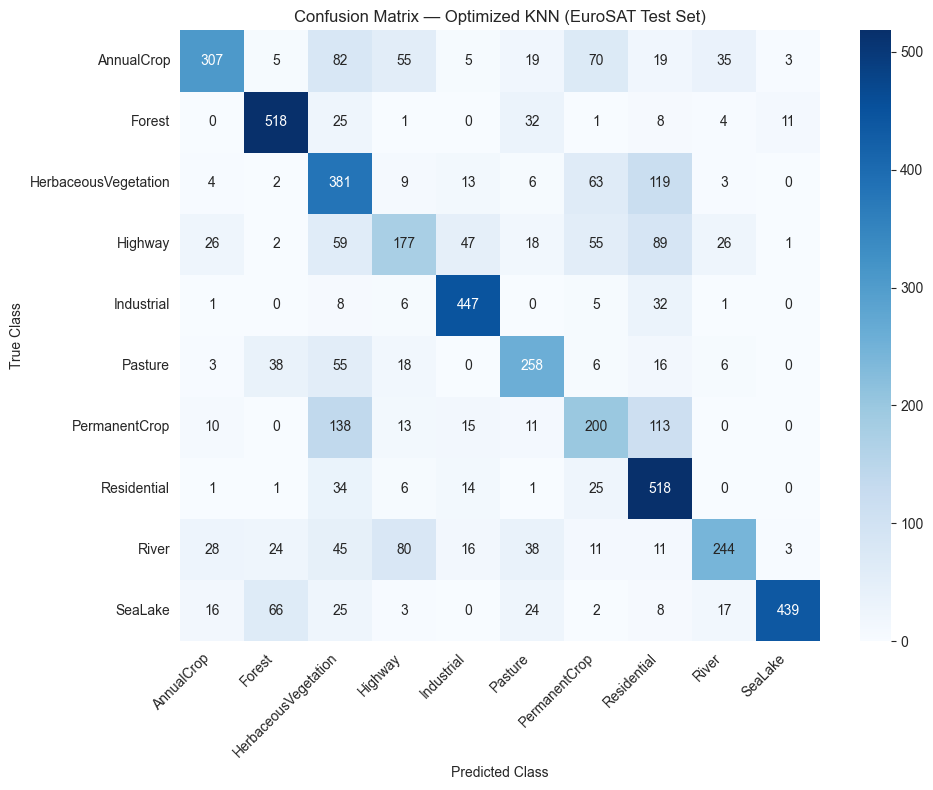

In [19]:
print("🧪 Evaluating model on the test set...")
y_pred = best_knn.predict(X_test)

# --- Calculate Metrics ---
acc = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=classes, digits=3)

print(f"\n✅ Test Accuracy: {acc*100:.2f}%")
print(f"🧩 Kappa Coefficient: {kappa:.3f}")
print("\n📊 Classification Report:\n", report)

# --- Visualization: Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix — Optimized KNN (EuroSAT Test Set)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Step 9 — Error Validation Function

Define a function to perform basic checks on an input image to see if it's likely a valid satellite image (e.g., RGB, reasonable brightness/variance, pixel range).

In [21]:
def validate_satellite_image(img_path):
    """Check if an input image likely comes from a satellite source (RGB)."""
    img = cv2.imread(img_path)
    if img is None:
        return False, f"❌ Cannot open image file: {img_path}"

    # Check pixel range first
    if not (img.min() >= 0 and img.max() <= 255):
         return False, f"⚠️ Pixel values out of range [0, 255]: min={img.min()}, max={img.max()}"

    # Convert to RGB (assuming read was BGR)
    try:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mean_val = np.mean(img_rgb)
        std_val  = np.std(img_rgb)
    except Exception as e:
         return False, f"❌ Error processing image color/stats: {e}"

    if img_rgb.ndim != 3 or img_rgb.shape[2] != 3:
        return False, f"❌ Image not 3-channel RGB (ndim={img_rgb.ndim}, channels={img_rgb.shape[-1]})."

    # Relaxed brightness/variance checks, adjust as needed
    if not (5 < mean_val < 250):
        return False, f"⚠️ Unusual average brightness: mean={mean_val:.1f} (typical range ~10-245)"

    if std_val < 5: 
        return False, f"⚠️ Very low variance (possibly flat/grayscale): std={std_val:.1f}"

    return True, f"✅ Image validated (mean={mean_val:.1f}, std={std_val:.1f})"

# --- Example Validation Calls ---
print("🔍 Running validation examples...")
# Use a path from the test set for a valid example
if paths_test:
    valid_path_example = paths_test[0] # Use first image from test set paths
    is_valid_test, msg_test = validate_satellite_image(valid_path_example)
    print(f"Validation for '{os.path.basename(valid_path_example)}': {msg_test}")
else:
    print("No test image paths available for validation example.")

# Example with a potentially problematic image (replace path if you have one)
fake_img_path = r'../fake_image.jpg' # Example path
if os.path.exists(fake_img_path):
    is_valid_fake, msg_fake = validate_satellite_image(fake_img_path)
    print(f"Validation for '{os.path.basename(fake_img_path)}': {msg_fake}")
else:
    print(f"Skipping fake image validation, file not found: {fake_img_path}")

🔍 Running validation examples...
Validation for 'AnnualCrop_2035.jpg': ✅ Image validated (mean=161.1, std=31.4)
Validation for 'fake_image.jpg': ✅ Image validated (mean=63.7, std=110.4)


### Step 10 — Save Model Components

Save the trained KNN model, the fitted StandardScaler, the fitted PCA transformer, and the list of class names for later use in prediction without retraining.

In [22]:
print("💾 Saving model components...")
joblib.dump(best_knn, "knn_eurosat_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(pca, "pca.pkl")
joblib.dump(classes, "class_names.pkl") 
print("✅ Model, scaler, PCA, and class names saved successfully.")

💾 Saving model components...
✅ Model, scaler, PCA, and class names saved successfully.


#### Step 10.1 — Load Components and Prediction Function

Load the saved components and define the function to predict a single image, including validation, feature extraction pipeline, confidence scores, top-3 classes, and visualization.

In [23]:
print("🔁 Loading model components for prediction...")
try:
    loaded_knn = joblib.load("knn_eurosat_model.pkl")
    loaded_scaler = joblib.load("scaler.pkl")
    loaded_pca = joblib.load("pca.pkl")
    loaded_classes = joblib.load("class_names.pkl")
    print("✅ Model components loaded successfully.")
except FileNotFoundError as e:
    print(f"❌ Error loading model files: {e}")
    print("Ensure steps 7, 8, and 10 ran successfully before prediction.")
    loaded_knn = None 
except Exception as e:
    print(f"❌ An unexpected error occurred during loading: {e}")
    loaded_knn = None

def predict_satellite_image(knn_model, scaler, pca, class_names, img_path, img_size=64, hist_bins=16):
    """Predict class, confidence, and top classes for a given satellite image path."""
    if knn_model is None or scaler is None or pca is None or class_names is None:
         print("❌ Model components not loaded. Cannot predict.")
         return None, None

    # 1. Validate the input image
    is_valid, msg = validate_satellite_image(img_path)
    print(f"\n🔍 Image Validation ({os.path.basename(img_path)}): {msg}")
    if not is_valid:
        print("❌ Prediction aborted due to invalid image.")
        return None, None

    # 2. Load and preprocess the image (same pipeline as training)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is None:
        print(f"❌ Cannot open image file for prediction: {img_path}")
        return None, None

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (img_size, img_size))
    img_filtered = cv2.medianBlur(img_resized, 3) # Apply same filtering

    # 3. Extract features (using the same function)
    features = extract_features_from_image(img_filtered, hist_bins=hist_bins)
    features = features.reshape(1, -1).astype(np.float32) # Reshape for scaler/pca

    # 4. Scale features using the loaded scaler
    try:
        features_scaled = scaler.transform(features)
    except Exception as e:
        print(f"❌ Error during scaling: {e}")
        return None, None

    # 5. Apply PCA transformation using the loaded PCA
    try:
        features_pca = pca.transform(features_scaled)
    except ValueError as e:
        print(f"❌ Error during PCA transformation: {e}")
        print(f"   Input feature shape: {features_scaled.shape}, PCA expects: {pca.n_features_in_}")
        return None, None
    except Exception as e:
        print(f"❌ Unexpected error during PCA transformation: {e}")
        return None, None

    # 6. Predict probabilities using the loaded KNN model
    try:
        probs = knn_model.predict_proba(features_pca)[0]
        top_indices = np.argsort(probs)[::-1][:3] # Get indices of top 3 probabilities
    except Exception as e:
        print(f"❌ Error during prediction: {e}")
        return None, None

    # 7. Format results
    main_pred_index = top_indices[0]
    main_class = class_names[main_pred_index]
    confidence = probs[main_pred_index] * 100

    print(f"\n🛰️ Predicted class: {main_class} ({confidence:.2f}% confidence)")
    print("📊 Top 3 Probable Classes:")
    for i in top_indices:
        print(f"  • {class_names[i]:<20}: {probs[i]*100:.2f}%")

    # 8. Visualization
    plt.figure(figsize=(5, 5))
    plt.imshow(img_resized) # Show the resized image used for features
    title = f"Prediction: {main_class} ({confidence:.1f}%)"
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    return main_class, confidence

print("✅ Prediction function defined.")

🔁 Loading model components for prediction...
✅ Model components loaded successfully.
✅ Prediction function defined.


#### Step 10.2 — Prediction Example

Run the prediction function on a random image from the test set to demonstrate its usage.


--- Predicting on a random image from the test set ---
Selected test image: ./EuroSAT/2750\Residential\Residential_479.jpg

🔍 Image Validation (Residential_479.jpg): ✅ Image validated (mean=108.7, std=14.7)

🛰️ Predicted class: Residential (87.33% confidence)
📊 Top 3 Probable Classes:
  • Residential         : 87.33%
  • HerbaceousVegetation: 12.67%
  • River               : 0.00%


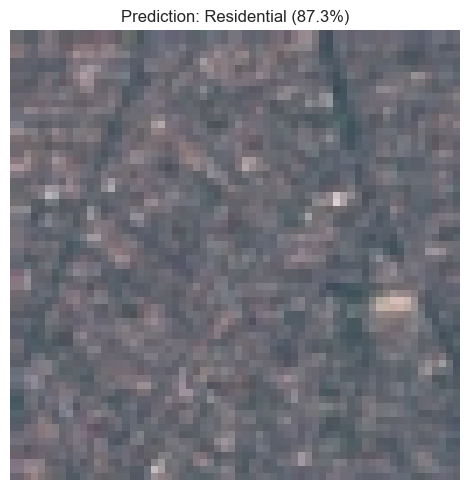


Actual True Class: Residential
✅ Prediction Correct!


In [24]:
# --- Predict on a random image from the test set ---
if loaded_knn and paths_test:
     print("\n--- Predicting on a random image from the test set ---")
     random_test_idx = random.randint(0, len(paths_test) - 1)
     random_test_path = paths_test[random_test_idx]
     print(f"Selected test image: {random_test_path}")
     
     # Call the prediction function
     predicted_class, prediction_confidence = predict_satellite_image(
         loaded_knn, loaded_scaler, loaded_pca, loaded_classes, 
         random_test_path, 
         img_size=IMG_SIZE, hist_bins=HIST_BINS
     )
     
     # Compare with known true class
     if predicted_class is not None: 
        true_class_known = y_test[random_test_idx]
        print(f"\nActual True Class: {true_class_known}")
        if predicted_class == true_class_known:
              print("✅ Prediction Correct!")
        else:
              print("❌ Prediction Incorrect.")

elif not loaded_knn:
     print("\nSkipping prediction example as model components were not loaded.")
else:
     print("\nSkipping prediction example as test image paths are not available.")


### Predict on a specific external image

In [ ]:
print("\n--- Predicting on a specific external image ---")
external_image_path = r"..\River_120.jpg" 
if os.path.exists(external_image_path):
     predict_satellite_image(loaded_knn, loaded_scaler, loaded_pca, loaded_classes, external_image_path)
else:
     print(f"External image not found at: {external_image_path}")

### 🚀 Step 11 — Accuracy Optimization Ideas

The KNN model achieved ~75-76% accuracy after median filtering and parameter tuning. Here are ideas to potentially improve results further, especially for weaker classes like **Highway**, **PermanentCrop**, and **Residential**:

1.  **Data Augmentation:**
    * **Why:** Increase training set diversity, especially for underperforming classes.
    * **How:** Apply random rotations, flips, zooms, brightness/contrast adjustments to training images *before* feature extraction. Retrain.

2.  **Feature Engineering:**
    * **Why:** Current features might miss crucial details (e.g., textures, lines).
    * **How:**
        * **Texture (GLCM):** Add Gray-Level Co-occurrence Matrix features (contrast, correlation, etc.).
        * **Edges/Lines (Canny, Hough):** Potentially helpful for 'Highway', 'River'.
        * **Shape (Moments):** Might help differentiate 'Industrial' vs. 'Residential'.

3.  **Advanced Noise Reduction:**
    * **Why:** Further improve feature quality.
    * **How:** Experiment with Gaussian Blur or Bilateral Filtering instead of Median Blur in Step 2.

4.  **Parameter Tuning (Further KNN):**
    * **Why:** Optimal K might change with different features/preprocessing.
    * **How:** Expand the `param_grid` (more neighbors, try 'Euclidean' distance again if features change significantly).

5.  **Class Balancing (Advanced):**
    * **Why:** Address potential subtle imbalances affecting weaker classes.
    * **How:** Use SMOTE on training data *only*, or classifiers supporting class weights (SVM, RF).